# Deep Learning for Skin Cancer Classification: A Convolutional Neural Network Approach
by match1

### Overview of the HAM10000 Dataset
Source: [Skin Cancer MNIST: HAM10000](https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000)

The HAM10000 (Human Against Machine with 10000 training images) dataset is a large collection of multi-source dermatoscopic images of common pigmented skin lesions. This dataset was released to facilitate the training of machine learning algorithms in dermatology. The dataset contains 10,015 dermatoscopic images, which serve as a representative collection of all important diagnostic categories in the realm of pigmented skin lesions. These images were collected from diverse populations and are annotated with labels for seven different types of skin lesions.


*The dataset is primarily used for:*
- Developing and benchmarking algorithms for the automated diagnosis of skin cancer.
- Comparing human and machine performance in dermatoscopic image analysis.
- Educating and training dermatologists in recognizing various skin lesions.

<br>

### Understanding Skin Cancer and the Role of Deep Learning in Its Detection

Skin cancer is one of the most prevalent forms of cancer globally, affecting millions of individuals each year. It occurs when skin cells undergo uncontrolled growth, often due to prolonged exposure to ultraviolet (UV) radiation from the sun or tanning beds.

Early detection of skin cancer is crucial as it significantly increases the chances of successful treatment and reduces the risk of severe complications or death. Traditionally, detection involves visual examinations, dermoscopy, biopsy, and histopathological analysis, all of which require significant time, resources, and expertise.

In recent years, deep learning, a branch of artificial intelligence (AI), has made significant strides in the medical field, particularly in the detection and diagnosis of skin cancer. Convolutional Neural Networks (CNNs), a type of deep learning model, have proven to be exceptionally effective in analyzing medical images and identifying patterns that may indicate the presence of skin cancer.

<br>

### Skin Lesion Categories

The dataset includes the following seven types of skin lesions:
1. Melanocytic nevi (`nv`)
2. Melanoma (`mel`)
3. Benign keratosis-like lesions (`bkl`)
4. Basal cell carcinoma (`bcc`)
5. Actinic keratoses (`akiec`)
6. Vascular lesions (`vasc`)
7. Dermatofibroma (`df`)

<br>

### Dataset Attributes

Below is a description of the key attributes (columns) included in the dataset:

| **Attribute**  | **Description**                                                                 |
|----------------|---------------------------------------------------------------------------------|
| `lesion_id`    | Unique identifier for each lesion                                               |
| `image_id`     | Unique identifier for each image                                                |
| `dx`           | Diagnosis label for the lesion (e.g., `mel`, `vasc`, `bcc`, etc.)         |
| `dx_type`      | Type of diagnosis, such as `histo` (histopathology), `follow_up`, `consensus`, or `confocal` |
| `age`          | Age of the patient at the time of image acquisition                             |
| `sex`          | Gender of the patient (`male` or `female`)                                      |
| `localization` | Localization of the lesion on the body (e.g., `back`, `lower extremity`, etc.)  |


### Importing Necessary Libraries

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import itertools
from glob import glob
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Loading and Reading the Dataset

In [5]:
# Load the dataset
df = pd.read_csv('../data/HAM10000_metadata.csv')

In [6]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [8]:
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [9]:
df.shape

(10015, 7)

### Data Preprocessing

In [10]:
df['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

##### Make a dictionary for the images and its labels (convert to more interpretable labels)

In [11]:
# Dictionary for the different lesion types
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Define the base directory where the image data is stored.
base_skin_dir = os.path.join('..', 'data')

# Dictionary that maps each image ID 
imageid_path_dict = {

    # For each image file path 'x', extract the base name (file name without the directory path)
    os.path.splitext(os.path.basename(x))[0]: x

    # glob returns a list of file paths 
    for x in glob(os.path.join(base_skin_dir, 'HAM10000_images_part_1', '*.jpg')) + 
             glob(os.path.join(base_skin_dir, 'HAM10000_images_part_2', '*.jpg'))
}

# This dictionary will have keys that are the image IDs (e.g., 'ISIC_0024306')
# and values that are the full paths to the corresponding image files (e.g., '../data/HAM10000_images_part_1/ISIC_0024306.jpg').

##### Add columns to df using the dictionary values

In [12]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,..\data\HAM10000_images_part_1\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,..\data\HAM10000_images_part_1\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,..\data\HAM10000_images_part_1\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,..\data\HAM10000_images_part_1\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,..\data\HAM10000_images_part_2\ISIC_0031633.jpg,Benign keratosis-like lesions,2


##### Data Cleaning

In [13]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [14]:
# Instead of dropping the 57 null values, we could just get the mean and fill the null values
df['age'] = df['age'].fillna(df['age'].mean())

In [15]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [16]:
df['age'] = df['age'].astype(int)

##### Image Processing
- Why Resize Images?
   + CNNs require input images to be of a fixed size
   + Larger images require more memory and computational power
- Let's resize the original dimensions of   450px x 600px   to   **125px x 100px**

In [17]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((125,100))))

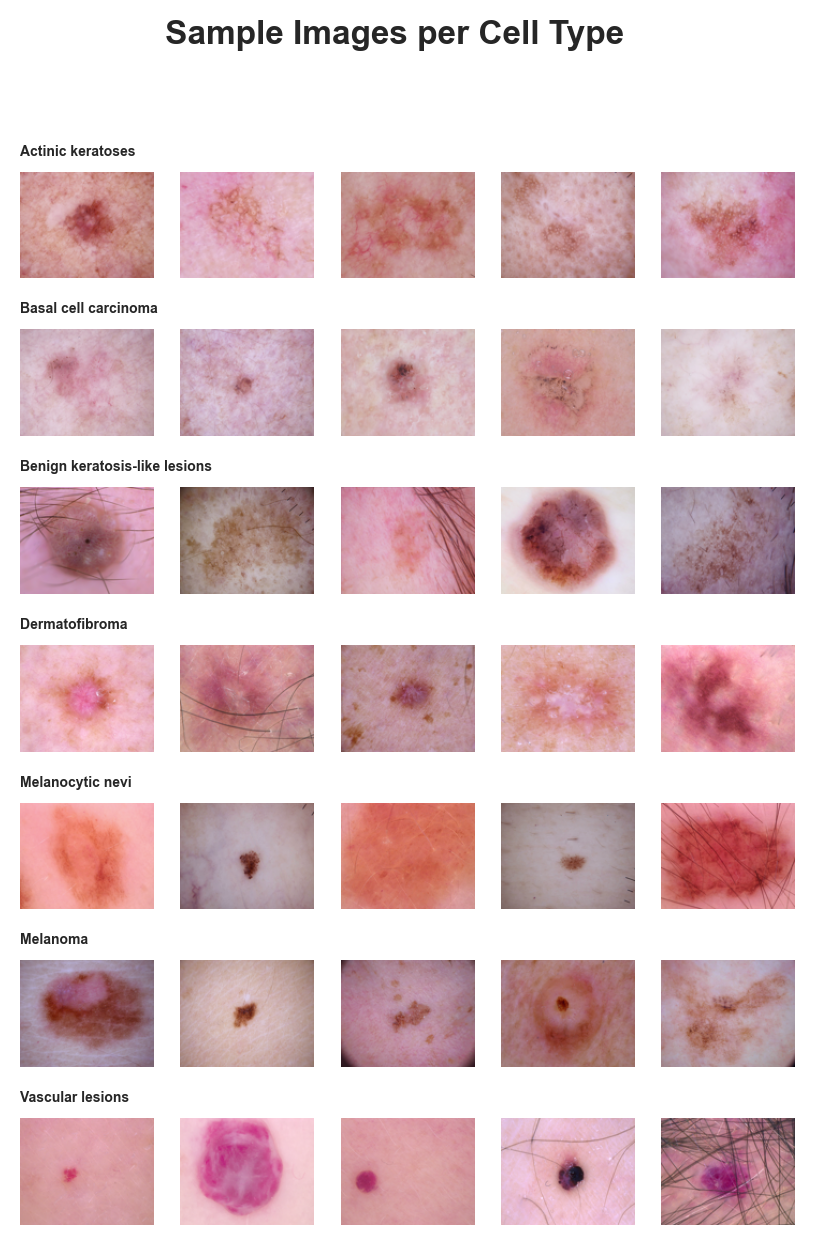

In [162]:
samples_per_row = 5

# Create a subplot grid with 7 rows and 4 columns
fig, m_axs = plt.subplots(7, samples_per_row, figsize=(5,7), dpi=200)

fig.suptitle('Sample Images per Cell Type', fontsize=12, fontweight='bold')

for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    
    # Set title of the first subplot in each row to the category name
    n_axs[0].set_title(type_name, fontsize=5, fontweight='bold', loc='left')
    
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(samples_per_row, random_state=1150).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')    

plt.show()

### Exploratory Data Analysis

In [19]:
df= df[df['age'] != 0]
df= df[df['sex'] != 'unknown']

##### Single-Variable Analysis

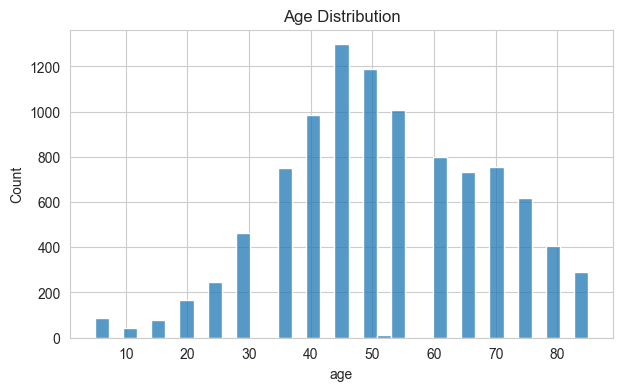

In [20]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(7,4))
ax = sns.histplot(data=df, x='age')
plt.title('Age Distribution')
plt.show()

- The highest frequency of individuals falls within the age range of 40 to 45 years old
- The probability of having skin cancer increases as age increases

In [21]:
# Function to plot df horizontally
def plot_horizontal_bar(df, column, title, figsize=(7, 4), palette='Spectral'):
    plt.figure(figsize=figsize) 
    plt.title(title, fontsize=15)  
    plt.xlabel("Count")
    
    value_counts = df[column].value_counts()
    
    sns.barplot(x=value_counts.values, 
                y=value_counts.index, 
                palette=palette,
                hue=value_counts.index, 
                legend=False) 
    
    plt.tight_layout()

    plt.show()

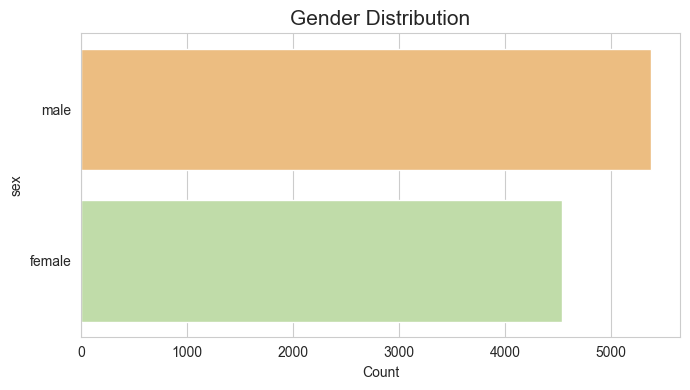

In [22]:
plot_horizontal_bar(df, 'sex', 'Gender Distribution')

- Skin cancer is more prominent in males than females

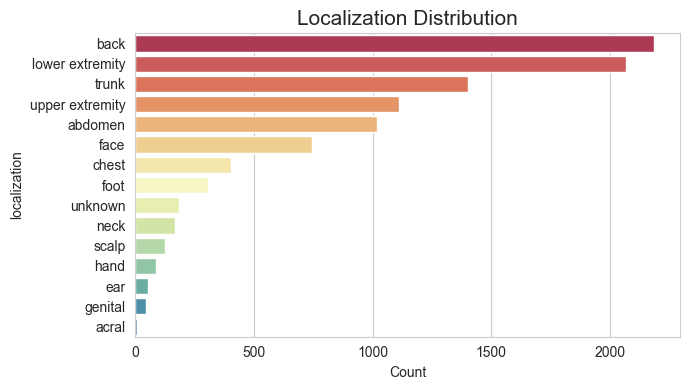

In [23]:
plot_horizontal_bar(df, 'localization', 'Localization Distribution')

- It appears that skin cancer lesions are most prevalent on the back and lower extremities This suggests that these areas are more susceptible to the development of skin cancer, possibly due to increased sun exposure.
- Other body parts with a significant number of lesions include the trunk and upper extremities.
- While less frequent, lesions are also observed on the head and neck, as well as the torso.
- It's important to note that the graph seems to indicate a lower incidence of lesions on areas like the palms, soles, and nails. This could be due to lower sun exposure or other factors influencing skin cancer development in these regions.

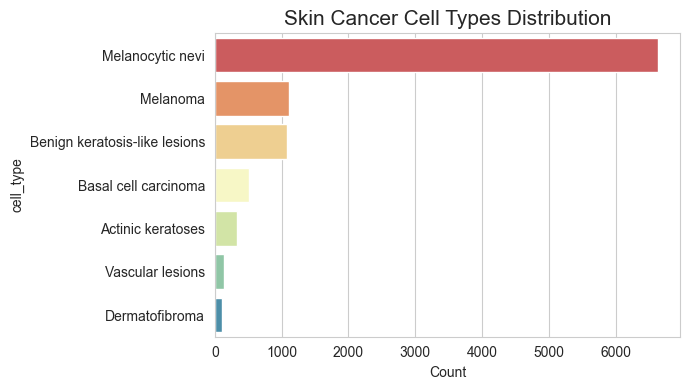

In [24]:
plot_horizontal_bar(df, 'cell_type', 'Skin Cancer Cell Types Distribution')

- Melanocytic nevi is the most prevalent cell type while Vascular lesions and dermatofibroma are the least represented cell types in the dataset.

##### Cross-Variable Analysis

In [25]:
# Function for two variable count bar plot
def plot_countplot(df, x_col, hue_col, title, palette='Set2', figsize=(9, 6)):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(figsize=figsize)
    count_plot = sns.countplot(x=x_col,
                               hue=hue_col,
                               data=df,
                               order=df[x_col].value_counts().index,
                               palette=palette,
                               ax=ax)


    plt.title(title)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [26]:
# Function for two variable stacked bar plot
def plot_stacked_bar(df, x_col, hue_col, title, palette='Set2', figsize=(9, 6)):
    sns.set_style('whitegrid')

    aggregated_data = df.groupby([x_col, hue_col]).size().unstack(fill_value=0)

    fig, ax = plt.subplots(figsize=figsize)
    
    aggregated_data.plot(kind='bar', stacked=True, colormap=palette, ax=ax)

    plt.title(title)
    plt.xlabel(x_col.capitalize())
    plt.ylabel("Count")
    plt.xticks(rotation=45)

    plt.legend(title=hue_col.capitalize(), bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    
    plt.show()

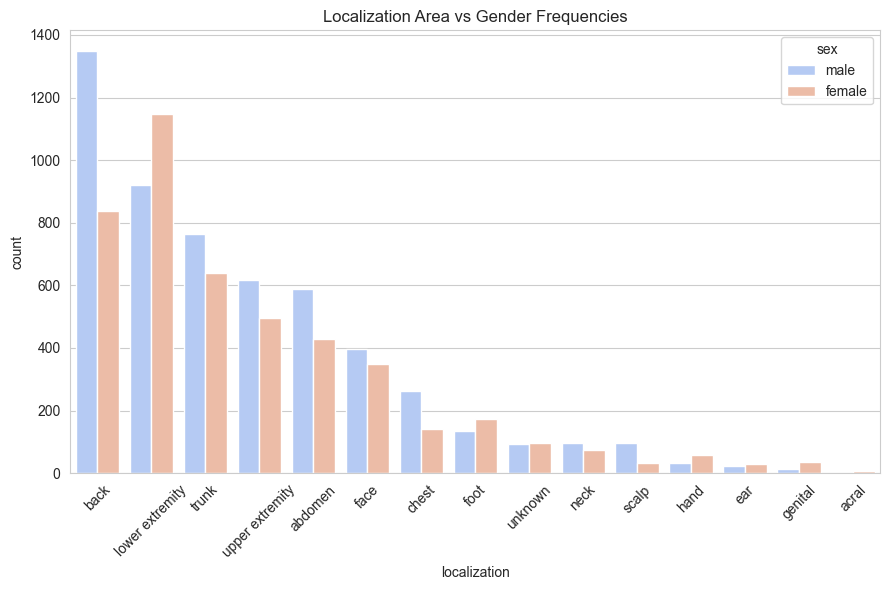

In [27]:
plot_countplot(df, x_col='localization', hue_col='sex', title='Localization Area vs Gender Frequencies', palette='coolwarm')

- Males tend to have a higher frequency of lesions on the back, trunk, and upper extremities compared to females. Females, on the other hand, exhibit a slightly higher frequency of lesions on the lower extremities and abdomen.

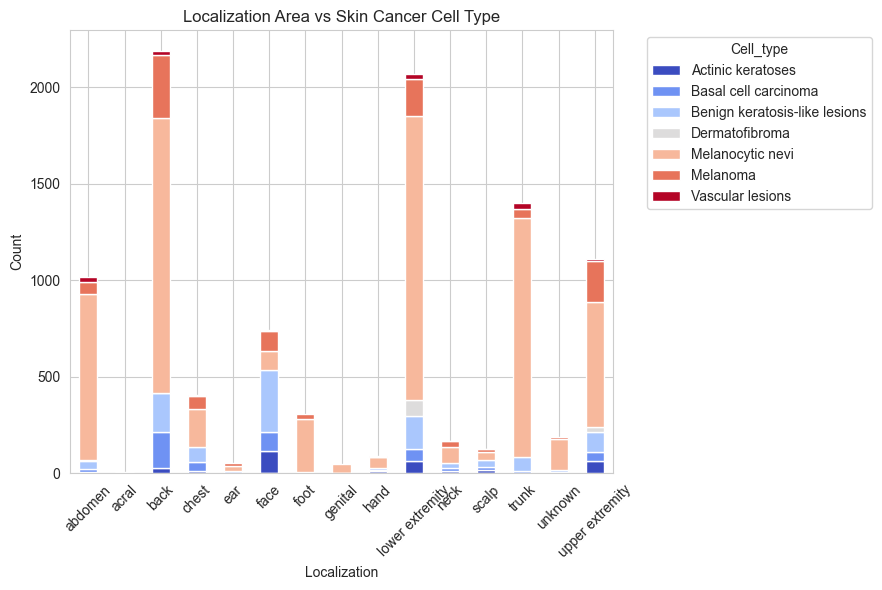

In [28]:
plot_stacked_bar(df, x_col='localization', hue_col='cell_type', title='Localization Area vs Skin Cancer Cell Type', palette='coolwarm')

- Melanocytic nevi is the most prevalent cell type across most localization areas, with particularly high counts on the back, lower extremity, and trunk.
- Actinic keratoses and basal cell carcinoma are frequently observed on the head and neck regions (face, ear, scalp).

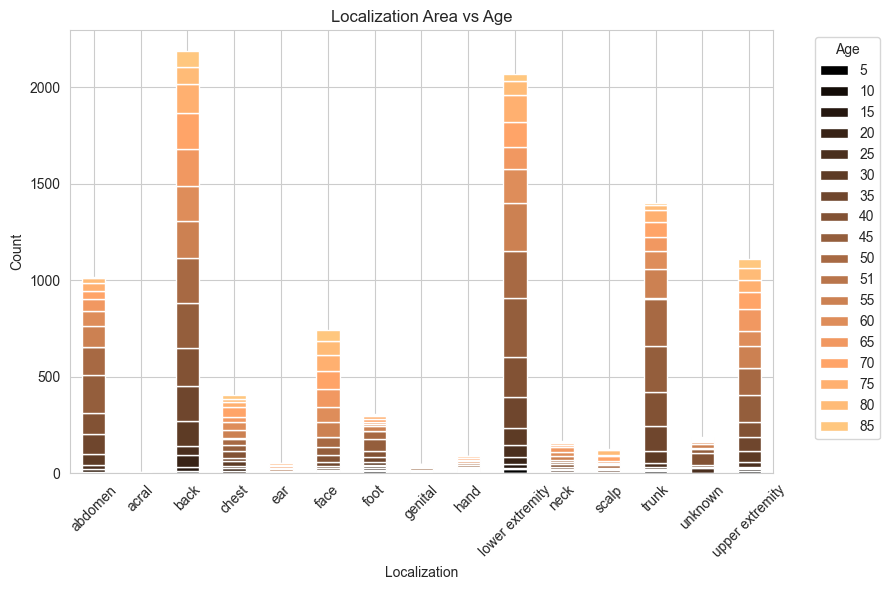

In [29]:
plot_stacked_bar(df, x_col='localization', hue_col='age', title='Localization Area vs Age', palette='copper')

- There seem to be peaks in lesion counts for certain age groups in specific localization areas. For example, the back and trunk show higher counts in the 40-50 age range.
- The distribution of ages varies across different localization areas. Some areas, like the face and scalp, have a more even distribution of ages, while others, like the lower extremity, show a concentration in younger age groups.

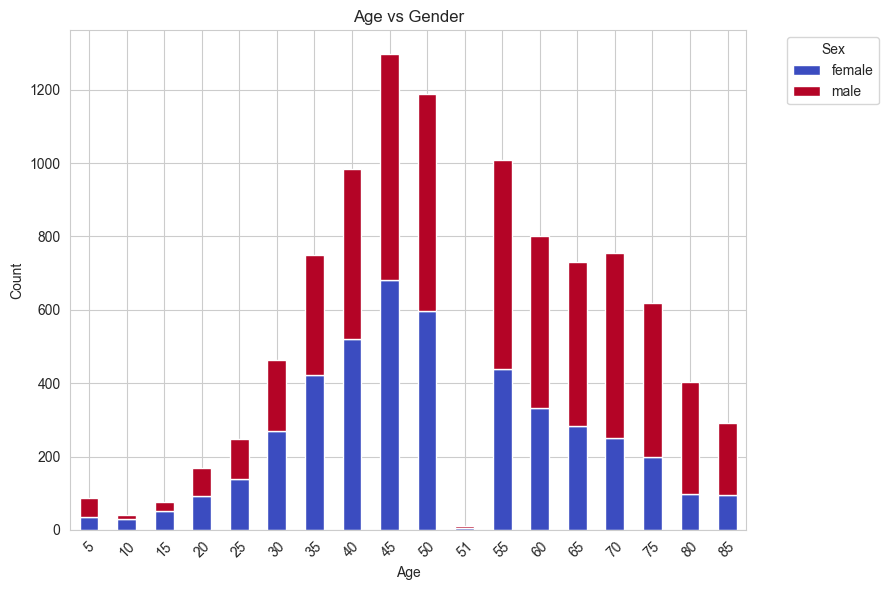

In [30]:
plot_stacked_bar(df, x_col='age', hue_col='sex', title='Age vs Gender', palette='coolwarm')

- The graph shows a higher number of females in younger age groups (10-30 years old).
- There's a clear shift towards a higher number of males in older age groups (50+ years old).

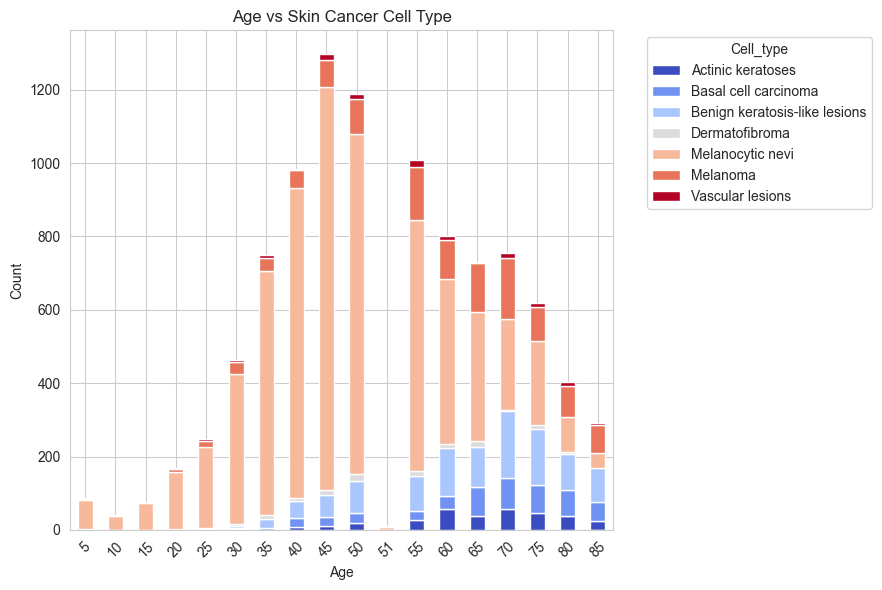

In [31]:
plot_stacked_bar(df, x_col='age', hue_col='cell_type', title='Age vs Skin Cancer Cell Type', palette='coolwarm')

- Melanocytic nevi are the most prevalent cell type across all age groups, with a significant peak in the 40-50 age range.
- Actinic keratoses and basal cell carcinoma show a gradual increase with age, becoming more common in older populations
- Benign keratosis-like lesions are more frequent in middle-aged individuals (40-60).
- Dermatofibroma has a relatively stable distribution across age groups.
- Melanoma shows a slight increase with age, with a peak around 50-60.
- Vascular lesions are less common and exhibit no clear age-related pattern

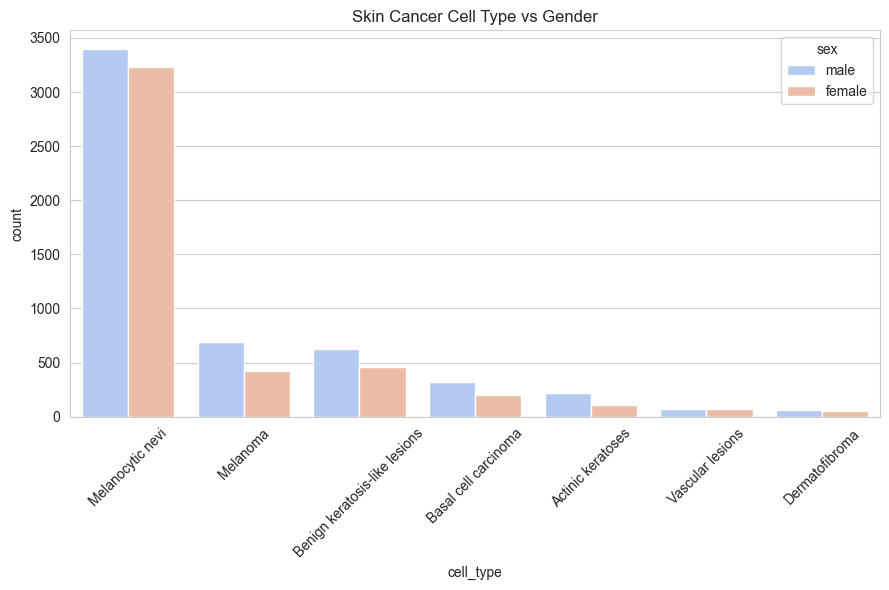

In [32]:
plot_countplot(df, x_col='cell_type', hue_col='sex', title='Skin Cancer Cell Type vs Gender', palette='coolwarm')

- Melanocytic nevi is the most common cell type for both males and females, with a significantly higher count in males.
- Melanoma is also more prevalent in males compared to females.   
- For cell types such as benign keratosis-like lesions, basal cell carcinoma, actinic keratoses, vascular lesions, and dermatofibroma, there appears to be a higher prevalence in males, though the differences are less pronounced compared to melanocytic nevi and melanoma.

### Data Modeling

##### Create features and labels data

In [115]:
# Get the image column 
X = np.array(df['image'].tolist())  # Convert list of arrays to a 4D numpy array
y = df['cell_type_idx']

##### Normalize images to the range [0, 1]

In [116]:
X = X.astype('float32') / 255.0

##### Split the data (Training, Testing, Validation)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=28, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=28, stratify=y_train)

In [118]:
print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}\nX_val shape: {X_val.shape}')
print(f'y_train shape: {y_train.shape}\ny_test shape: {y_test.shape}\ny_val shape: {y_val.shape}')

X_train shape: (6696, 100, 125, 3)
X_test shape: (2481, 100, 125, 3)
X_val shape: (744, 100, 125, 3)
y_train shape: (6696,)
y_test shape: (2481,)
y_val shape: (744,)


##### Use one-hot encoding on the labels

In [119]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)
y_val = to_categorical(y_val, num_classes = 7)
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

##### Defining the model

- **Input Layer**: Accepts images of size `(100, 125, 3)`.

- **Convolutional Blocks**:
  - Multiple `Conv2D` layers with increasing filters (32, 64, 128, 256).
  - `MaxPooling2D` layers to reduce spatial dimensions.
  - `BatchNormalization` layers for faster convergence and stability.
  - `Dropout` layers after some blocks to prevent overfitting.
  - L2 regularization applied to selected `Conv2D` layers.

- **Dense (Fully Connected) Layers**:
  - `Flatten` the output from the final convolutional block.
  - Sequential `Dense` layers with decreasing units (512, 256, 128, 64).
  - `BatchNormalization` and `Dropout` applied to enhance performance and generalization.

- **Output Layer**:
  - `Dense` layer with 7 units and softmax activation for classification into 7 classes.

In [120]:
model = models.Sequential()

# Initial Convolutional Block
model.add(layers.Input(shape=[100, 125, 3]))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())

# Second Convolutional Block
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.L2(0.01)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))  

# Third Convolutional Block
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.L2(0.01)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5)) 

# Fourth Convolutional Block
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.L2(0.01)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Flatten and Dense Layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.L2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.L2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.L2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.L2(0.01)))
model.add(layers.BatchNormalization())

# Output Layer
model.add(layers.Dense(7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [121]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 100, 125, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 50, 62, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 50, 62, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_20 (Conv2D)          (None, 50, 62, 64)        18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 50, 62, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 25, 31, 64)      

In [122]:
# Stops training if validation loss doesn't improve for 5 epochs and restores the best model weights.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [123]:
# Define learning rate reduction callback
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

##### Data Augmentation

The `ImageDataGenerator` is used to artificially increase the diversity of the training dataset by applying random transformations like rotation, shifting, shearing, zooming, and flipping. This helps the model generalize better and reduces overfitting.

In [124]:
datagen = ImageDataGenerator(
    rotation_range=20,           # Randomly rotate images by up to 20 degrees.
    width_shift_range=0.2,       # Randomly shift images horizontally by up to 20% of the width.
    height_shift_range=0.2,      # Randomly shift images vertically by up to 20% of the height.
    shear_range=0.2,             # Apply random shearing transformations.
    zoom_range=0.2,              # Randomly zoom in/out on images by up to 20%.
    horizontal_flip=True,        # Randomly flip images horizontally.
    fill_mode='nearest'          # Fill in any pixels lost after transformations using the nearest pixel values.
)

### Fitting the Model

In [125]:
# Augmented data generator
train_generator = datagen.flow(X_train, y_train, batch_size=32)

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,  # Calculate the number of batches per epoch
    epochs=25,
    validation_data=(X_val, y_val),
    callbacks=[learning_rate_reduction, early_stopping]
)

Epoch 1/25
209/209 [==============================] - 307s 1s/step - loss: 22.7874 - accuracy: 0.4967 - val_loss: 15.9536 - val_accuracy: 0.2984 - lr: 0.0010
Epoch 2/25
209/209 [==============================] - 386s 2s/step - loss: 9.3445 - accuracy: 0.6474 - val_loss: 6.2803 - val_accuracy: 0.6707 - lr: 0.0010
Epoch 3/25
209/209 [==============================] - 768s 4s/step - loss: 4.6860 - accuracy: 0.6583 - val_loss: 3.4591 - val_accuracy: 0.6680 - lr: 0.0010
Epoch 4/25
209/209 [==============================] - 889s 4s/step - loss: 2.8043 - accuracy: 0.6580 - val_loss: 2.4006 - val_accuracy: 0.6815 - lr: 0.0010
Epoch 5/25
209/209 [==============================] - 353s 2s/step - loss: 2.0283 - accuracy: 0.6696 - val_loss: 1.7047 - val_accuracy: 0.6734 - lr: 0.0010
Epoch 6/25
209/209 [==============================] - ETA: 0s - loss: 1.6441 - accuracy: 0.6667
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
209/209 [==============================] - 303

In [140]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [126]:
test_loss, test_acc = model.evaluate(X_test, y_test)
val_loss, val_acc = model.evaluate(X_val, y_val)

print("Test: accuracy = %f  ;  loss = %f" % (test_acc, test_loss))
print("Validation: accuracy = %f  ;  loss_v = %f" % (val_acc, val_loss))

24/24 [==============================] - 5s 197ms/step - loss: 0.7908 - accuracy: 0.7513
Test: accuracy = 0.749295  ;  loss = 0.806915
Validation: accuracy = 0.751344  ;  loss_v = 0.790755


The model shows decent performance with both the test and validation **accuracy close to 75%**, indicating that it is learning the task well but still has room for improvement. The loss values are slightly lower on the validation set compared to the test set, suggesting the model generalizes fairly well to unseen data. Further fine-tuning or more data could help in improving the model’s accuracy.

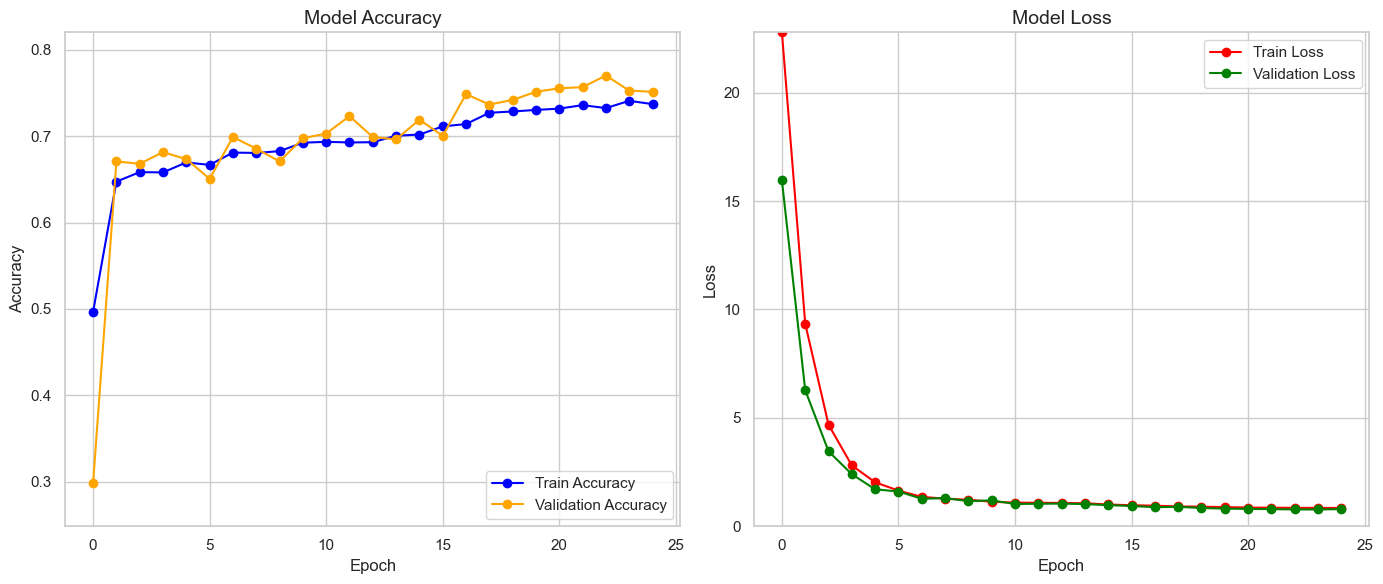

In [136]:
sns.set(style="whitegrid")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot Accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linestyle='-', marker='o')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='-', marker='o')
ax1.set_title('Model Accuracy', fontsize=14)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)

# Get min and max values
min_acc = min(min(history.history['accuracy']), min(history.history['val_accuracy']))
max_acc = max(max(history.history['accuracy']), max(history.history['val_accuracy']))

# Add padding (e.g., 0.05 to both sides)
padding = 0.05
ax1.set_ylim([min_acc - padding, max_acc + padding])

ax1.legend(loc='lower right')
ax1.grid(True)


# Plot Loss
ax2.plot(history.history['loss'], label='Train Loss', color='red', linestyle='-', marker='o')
ax2.plot(history.history['val_loss'], label='Validation Loss', color='green', linestyle='-', marker='o')
ax2.set_title('Model Loss', fontsize=14)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_ylim([0, max(max(history.history['loss']), max(history.history['val_loss']))])
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()

plt.show()

- **Accuracy Plot (Left):**
    - `Training Accuracy`: Seems to have stabilized around a value slightly above 0.6, with minor fluctuations.
    - `Validation Accuracy`: follows a similar trend but fluctuates more than the training accuracy.

- **Loss Plot (Right):**
    - `Training Loss`: shows a steep decrease in training loss during the initial epochs and then stabilizes, indicating that the model is learning and reducing errors on the training data.
    - `Validation Loss`: also decreases rapidly and then stabilizes, suggesting that the model is not overfitting.

- **Overall Evaluation:**
    - Both training and validation accuracy have reached a plateau, which suggests that the model might be nearing its capacity to learn from the given data without further significant improvements.
    - The close alignment of training and validation loss curves indicates that the tweaks (like data augmentation, reduced learning rate, early stopping, etc.) have helped in mitigating overfitting.

Predict the values from the validation dataset

In [156]:
Y_pred = model.predict(X_val)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 

# compute confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

24/24 [==============================] - 4s 167ms/step


Plot Confusion Matrix

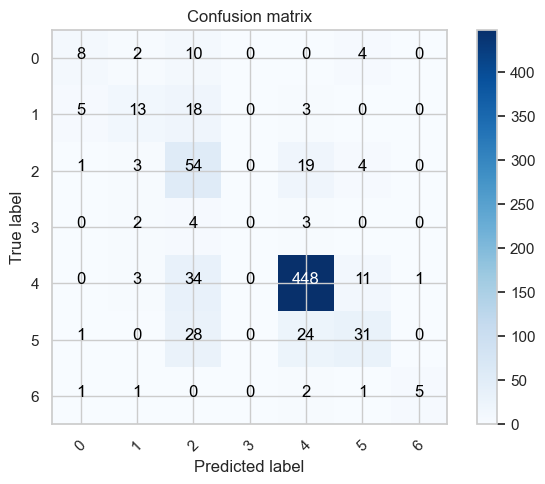

In [157]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

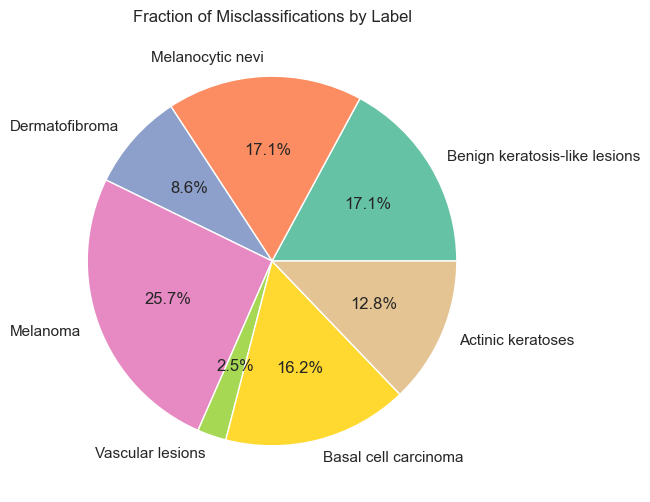

In [159]:
# Calculate fraction of errors
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_frac_error, labels=list(reverse_label_mapping.values()), autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Fraction of Misclassifications by Label')
plt.show()

- `Melanoma` has the highest fraction of errors at 25.7%, indicating that the model struggles the most in correctly classifying this condition.
- `Vascular lesions` have the lowest fraction of errors at 2.5%, suggesting that the model is most accurate in identifying this type of skin condition.
- Other labels like `Benign keratosis-like lesions`, `Melanocytic nevi`, and `Actinic keratoses` also have relatively high fractions of errors, indicating areas where the model could be improved.